In [1]:
from tb_hamiltonian.continuum import GrapheneContinuumModel
import numpy as np

from tb_hamiltonian.continuum import compute_eigenstuff, interpolate_path
from tb_hamiltonian.utils import BandStructure

inputs = dict(
    bond_length=1.425,
    interlayer_hopping=0.22,
    superlattice_potential_periodicity=500,
    superlattice_potential_amplitude=10e-3,
    gate_bias=-5e-3,
    layer_potential_ratio=0.3,
    nearest_neighbor_order=3,
)

model = GrapheneContinuumModel(**inputs)

In [2]:
# Generate high-symmetry points in the mini Brillouin zone (BZ)
b1, b2 = model.Qn[0], model.Qn[1]

high_sym_points={
    "Γ": np.array([0.0, 0.0]),
    "M": b1 / 2,
    "K": (b1 + b2) / 3,
}

Gamma = np.array([0.0, 0.0])
M = b1 / 2
K = (b1 + b2) / 3

path = "Γ K M Γ"
path_points = [high_sym_points[k] for k in path.split()]
kpath, k_point_indices = interpolate_path(path_points, total_points=100)
eigenvalues, _ = compute_eigenstuff(model.H_total_K, kpath)

nbands = eigenvalues.shape[1]
mid_band = int(nbands / 2)
EF = (np.min(eigenvalues[:, mid_band]) + np.max(eigenvalues[:, mid_band - 1])) / 2

In [5]:
nbands

148

In [8]:
model.H_total_K(np.array([0, 0])).shape[0]

148

In [6]:
EF

0.0014542548168033256

In [3]:
bs = BandStructure(
    high_sym_points=high_sym_points,
    path=path,
    distances=[*range(len(eigenvalues))],
    eigenvalues=eigenvalues,
    high_sym_indices=k_point_indices,
    e_fermi=EF,
)

<AxesSubplot:title={'center':'Band Structure'}, ylabel='Energy (eV)'>

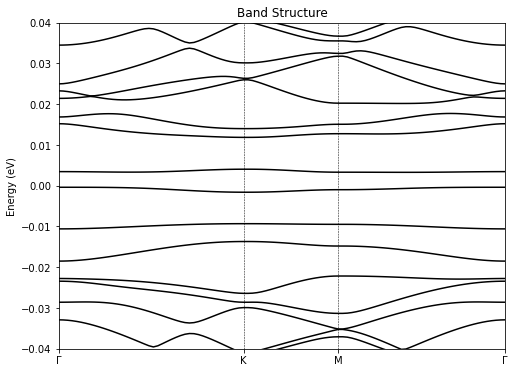

In [4]:
bs.plot(fig_params={"ylim": (-0.04, 0.04)}, plot_params={"color": "black"})

In [2]:
import numpy as np
from scipy.integrate import nquad

def compute_berry_curvature(kx, ky, H_calculator, bnd_idx, degenerate, delta=1e-2):
    # sourcery skip: inline-immediately-returned-variable
    """Compute the Berry curvature at a given k-point (kx, ky) using finite differences."""
    kpoints = np.array([[kx, ky], [kx + delta, ky], [kx, ky + delta], [kx + delta, ky + delta]])

    # Compute the eigenvalues and eigenvectors at the relevant k-points
    _, psi = compute_eigenstuff(H_calculator, [kpoints[0]])
    _, psi_right = compute_eigenstuff(H_calculator, [kpoints[1]])
    _, psi_up = compute_eigenstuff(H_calculator, [kpoints[2]])
    _, psi_diag = compute_eigenstuff(H_calculator, [kpoints[3]])

    # Extract the wavefunction for the specific band
    psi = psi[:, :, bnd_idx]
    psi_right = psi_right[:, :, bnd_idx]
    psi_up = psi_up[:, :, bnd_idx]
    psi_diag = psi_diag[:, :, bnd_idx]
    # print(psi.shape)

    # Overlaps between wavefunctions at neighboring k-points
    if degenerate:
        Ox = np.linalg.det(np.dot(psi[0].conj().T, psi_right[0]))
        Oy = np.linalg.det(np.dot(psi_right[0].conj().T, psi_diag[0]))
        Ox_reverse = np.linalg.det(np.dot(psi_diag[0].conj().T, psi_up[0]))
        Oy_reverse = np.linalg.det(np.dot(psi_up[0].conj().T, psi[0]))

    else:
        Ox = np.vdot(psi, psi_right)
        Oy = np.vdot(psi_right, psi_diag)
        Ox_reverse = np.vdot(psi_diag, psi_up)
        Oy_reverse = np.vdot(psi_up, psi)

    # Wilson loop Berry curvature
    berry_phase = np.imag(np.log(Ox * Oy * Ox_reverse * Oy_reverse))
    berry_curvature = -berry_phase / (delta**2)
    return berry_curvature


def integrate_berry_curvature(H_calculator, bnd_idx,  a=1.0,degenerate=False):
    """Integrate the Berry curvature over the entire Brillouin zone using scipy.nquad."""
    def integrand(kx, ky):
        return compute_berry_curvature(kx, ky, H_calculator, bnd_idx, degenerate)

    # Limits for kx and ky integration over the Brillouin zone
    kx_limits = (-np.pi/a, np.pi/a)
    ky_limits = (-2*np.pi/(np.sqrt(3)*a), 2*np.pi/(np.sqrt(3)*a))

    # Perform the numerical integration using nquad
    result, _ = nquad(integrand, [kx_limits, ky_limits], opts={'epsabs': 1e-5, 'epsrel': 1e-5, 'limit': 1000})
    # Chern number is the integral of Berry curvature divided by 2π
    chern_number = result / (2 * np.pi)
    return chern_number


In [6]:
H_calculator = model.H_total_K
bnd_idx = 15
a = inputs["superlattice_potential_periodicity"]
chern_number = integrate_berry_curvature(H_calculator, bnd_idx=bnd_idx, a=a, degenerate=False)
print("Chern number:", chern_number)

KeyboardInterrupt: 